In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

dfs = []
for name in ["results_mixed_complexity_0.csv",
             "results_mixed_complexity_1.csv",
             "results_mixed_new_0.csv",
             "results_mixed_new_1.csv", 
             "results_mixed_0_2.csv", 
             "results_mixed_1_3.csv",
             "results_mixed_infidelity.csv",
             "results_mixed_cams_0.csv",
             "results_mixed_cams_1.csv",
             "results_mixed_cams_2.csv",
             "results_mixed_cams_3.csv",]:
    df = pd.read_csv(name)
    # Replace all the Nans with 0s
    df = df.fillna(0)
    dfs.append(df)

# Concatenate the two dataframes
df = pd.concat(dfs, ignore_index=True)

df = df[df["Dataset"] == "Imagenettewoof"]

# df = df[df["Predicted Label"] != df["Label"]]
# df = df[df["Label"] >= 10]

In [2]:
# Pivot the data to get 'average_drop' and 'insertion_curve_AUC' side-by-side
pivoted = df.pivot_table(
    index=['Image Index', 'Label', 'Predicted Label', 'Model', 'Dataset',
           'Attribution Method', 'Layer', 'Upscale Method', 'Mixing Method'],
    columns='Metric',
    values='Value',
    aggfunc='first'  # or 'mean' if there are duplicates and you want the mean
).reset_index()

pivoted["complexity"] = pivoted["complexity"].astype(float) / 224
pivoted["average_drop"] = pivoted["average_drop"].astype(float) / 100

# Calculate the harmonic mean
pivoted['ADCC'] = pivoted.apply(
    lambda row: 3*((1/row['coherency']) + (1 / (1 - row["complexity"])) + (1 / (1 - row['average_drop'])))**-1,
    # if pd.notnull(row['average_drop']) and pd.notnull(row['insertion_curve_AUC']) else None,
    axis=1
)

In [3]:
# First, melt back the metric columns (including your new ADCC one)
melted = pivoted.melt(
    id_vars=['Image Index', 'Label', 'Predicted Label', 'Model', 'Dataset',
             'Attribution Method', 'Layer', 'Upscale Method', 'Mixing Method'],
    value_vars=['average_drop', 'insertion_curve_AUC', 'deletion_curve_AUC', 'coherency', 'complexity', 'ADCC','road_combined', 'infidelity'],
    var_name='Metric',
    value_name='Value'
)

# Optional: sort or reset index if needed
melted = melted.sort_values(by=['Image Index', 'Metric']).reset_index(drop=True)

df = melted.copy()

In [4]:
methods = df["Attribution Method"].unique()
layers = df["Layer"].unique()
metrics = df["Metric"].unique()
upscale_methods = df["Upscale Method"].unique()
mixing_methods = df["Mixing Method"].unique()

In [5]:
print("Methods:", methods)
print("Layers:", layers)
print("Metrics:", metrics)
print("Upscale Methods:", upscale_methods)
print("Mixing Methods:", mixing_methods)

Methods: ['EigenCAM' 'GradCAMPlusPlus' 'LayerCAM' 'ScoreCAM']
Layers: ['features.10' 'features.15' 'features.20' 'features.5']
Metrics: ['ADCC' 'average_drop' 'coherency' 'complexity' 'deletion_curve_AUC'
 'infidelity' 'insertion_curve_AUC' 'road_combined']
Upscale Methods: ['ERFUpsamplingFast' 'bilinearUpsampling']
Mixing Methods: [0 'MultiplierMix']


In [53]:
df

,Image Index,Label,Predicted Label,Model,Dataset,Attribution Method,Layer,Upscale Method,Mixing Method,Metric,Value
0,4,6,18,VGG11,Imagenettewoof,GradCAMPlusPlus,features.10,ERFUpsamplingFast,0,ADCC,0.302873
1,4,6,18,VGG11,Imagenettewoof,GradCAMPlusPlus,features.10,ERFUpsamplingFast,MultiplierMix,ADCC,0.092421
2,4,6,18,VGG11,Imagenettewoof,GradCAMPlusPlus,features.10,bilinearUpsampling,0,ADCC,0.401224
3,4,6,18,VGG11,Imagenettewoof,GradCAMPlusPlus,features.10,bilinearUpsampling,MultiplierMix,ADCC,0.907433
4,4,6,18,VGG11,Imagenettewoof,GradCAMPlusPlus,features.15,ERFUpsamplingFast,0,ADCC,0.005946
...,...,...,...,...,...,...,...,...,...,...,...
31739,993,13,12,VGG11,Imagenettewoof,GradCAMPlusPlus,features.20,bilinearUpsampling,MultiplierMix,road_combined,0.198115
31740,993,13,12,VGG11,Imagenettewoof,GradCAMPlusPlus,features.5,ERFUpsamplingFast,0,road_combined,0.169996
31741,993,13,12,VGG11,Imagenettewoof,GradCAMPlusPlus,features.5,ERFUpsamplingFast,MultiplierMix,road_combined,0.197343
31742,993,13,12,VGG11,Imagenettewoof,GradCAMPlusPlus,features.5,bilinearUpsampling,0,road_combined,0.180709


In [6]:
import sys
sys.path.append('../')

from models import vgg11_Imagenettewoof, vgg_preprocess
import torch
from data import imagenettewoof
model = vgg11_Imagenettewoof()
# Load weights
model.load_state_dict(torch.load("VGG11_Imagenettewoof.pt", map_location='cpu'))

# test_data = imagenettewoof(root="../data", split="test", size="320px", download=False, transform=vgg_preprocess)

layer_types = {}
types = []
for i, layer in enumerate(layers):
    layer_type = model.features[int(layer.split(".")[-1])].__class__.__name__
    layer_types[layer] = layer_type
    if layer_type not in types:
        types.append(layer_type)

print(types)
print(layer_types)

['MaxPool2d']
{'features.10': 'MaxPool2d', 'features.15': 'MaxPool2d', 'features.20': 'MaxPool2d', 'features.5': 'MaxPool2d'}


ERFUpsamplingFast
        Image Index  Label  Predicted Label  Model         Dataset  \
448               0      2                2  VGG11  Imagenettewoof   
452               0      2                2  VGG11  Imagenettewoof   
456               0      2                2  VGG11  Imagenettewoof   
460               0      2                2  VGG11  Imagenettewoof   
960               1      6                6  VGG11  Imagenettewoof   
...             ...    ...              ...    ...             ...   
511300          998     18               18  VGG11  Imagenettewoof   
511737          999     19               19  VGG11  Imagenettewoof   
511741          999     19               19  VGG11  Imagenettewoof   
511745          999     19               19  VGG11  Imagenettewoof   
511749          999     19               19  VGG11  Imagenettewoof   

       Attribution Method        Layer     Upscale Method Mixing Method  \
448              EigenCAM  features.10  ERFUpsamplingFast         

<Figure size 640x480 with 0 Axes>

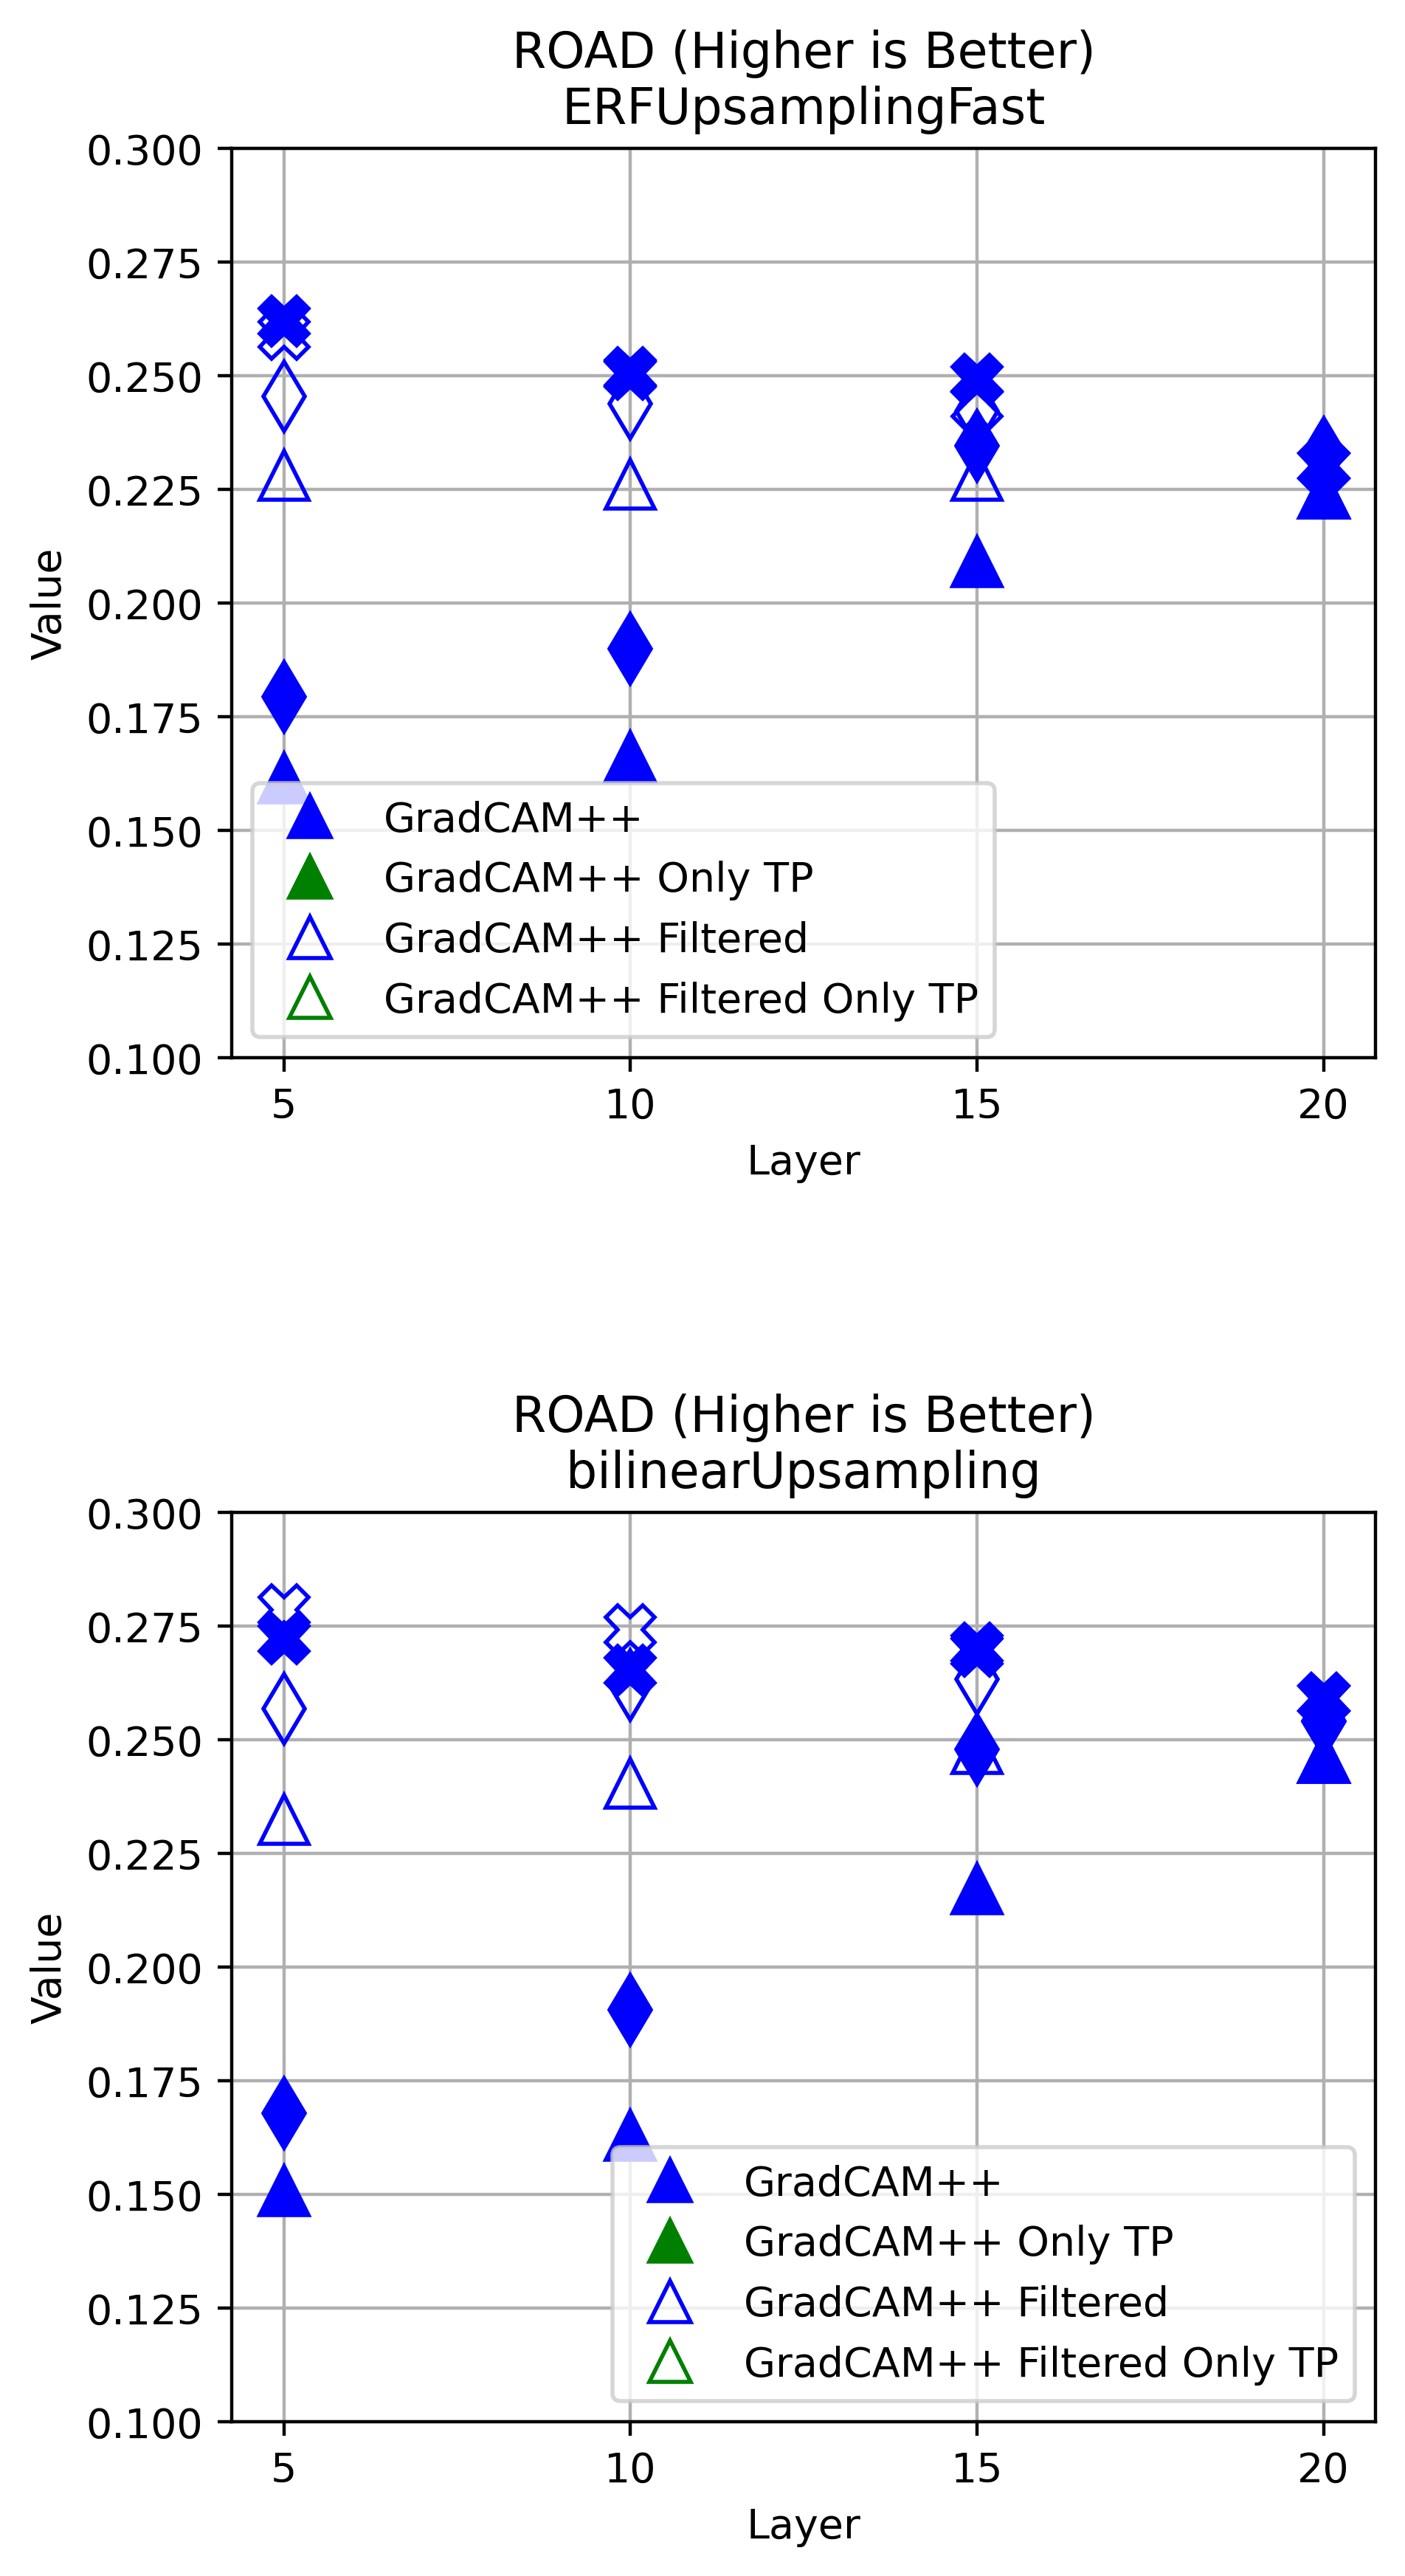

In [ ]:
import matplotlib.lines as mlines


color_for_layers = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
# shape_for_upscale = {"ERFUpsampling": "P","SimpleUpsampling": "D"}  # Define shape mapping
shape_for_methods = {"GradCAMPlusPlus": "^", "EigenCAM": "H", "LayerCAM": "X", "ScoreCAM": "d"}  # Define shape mapping

method_names = {"GradCAMPlusPlus": r"GradCAM++ NOT Filtered", "DeepLiftShap8": "DeepLiftShap Bilinear Upsampling"}  # Define shape mapping
# upscale_names = {"ERFUpsampling": "ERF Upsampling", "SimpleUpsampling": "Bilinear Upsampling"}  # Define shape mapping
titles = {
    "sensitivity": "Sensitivity (Lower is Better)",
    "infidelity": "Infidelity (Lower is Better)",
    "road_combined": "ROAD (Higher is Better)",
    "ADCC": "ADCC (Higher is Better)",
    "average_drop": "Average Drop (Lower is Better)",
    "coherency": "Coherency (Higher is Better)",
    "complexity": "Complexity (Lower is Better)",
    "deletion_curve_AUC": "Deletion Curve AUC (Lower is Better)",
    "insertion_curve_AUC": "Insertion Curve AUC (Higher is Better)",
}

# fig.text(0.05, 0.75, 'GradCAM++', ha='center', va='center', fontsize=14) # , fontweight='bold')
# fig.text(0.05, 0.25, 'DeepLiftShap', ha='center', va='center', fontsize=14) # , fontweight='bold')

# plt.suptitle('Infidelity comparison between Filtered and NOT Filtered', fontsize=16)
plt.tight_layout()

# metrics = ['road_combined',
#            'deletion_curve_AUC',
#            'insertion_curve_AUC',
#            'infidelity',
#            'average_drop',
#            'coherency',
#            'complexity',
#            'ADCC']

metrics = ["road_combined"]

fig = plt.figure(figsize=(5*len(metrics),10), dpi=400)

for metric_index, metric in enumerate(metrics):
    df_metric = df[df["Metric"] == metric]
    # plt.subplot(3, 2,)
    for index, upscale in enumerate(upscale_methods):
        print(upscale)
        plt.subplot(2, len(metrics), index * len(metrics) + metric_index + 1)
        plt.title(titles[metric] + "\n" + upscale)
        for layer_type in types:
            for mix in mixing_methods:
                for j, attr_method in enumerate(methods):
                    df_correct = df_metric[df_metric["Label"] == df_metric["Predicted Label"]]
                    for df_index, grouped in enumerate([df_metric]):
                        res = grouped[(grouped["Upscale Method"] == upscale) &
                                (grouped["Attribution Method"] == attr_method) & 
                                (grouped["Mixing Method"] == mix)]
                        
                        print(res)
                        res = res.groupby("Layer").agg({"Value": ["mean","std","count"]}).reset_index()
                        res["Layer"] = res["Layer"].apply(lambda x: int(x.split(".")[-1]))
                    
                        if mix == "MultiplierMix":
                            # print("SimpleUpsampling")
                            plt.plot(res["Layer"], res["Value","mean"],shape_for_methods[attr_method],markerfacecolor= 'none', color=color_for_layers[df_index], markersize=12)
                            # plt.errorbar(res["Layer"], res["Value","mean"], yerr=1.96 * res["Value","std"] / res["Value","count"], fmt='o', color=color_for_layers[types.index(layer_type)], markersize=2, capsize=2)
                        else:
                            plt.plot(res["Layer"], res["Value","mean"],shape_for_methods[attr_method], color=color_for_layers[df_index], markersize=12)
                            # plt.errorbar(res["Layer"], res["Value","mean"], yerr=1.96 * res["Value","std"] / res["Value","count"], fmt='o', color=color_for_layers[types.index(layer_type)], markersize=2, capsize=2)
                            # print("ERFUpsampling")

                        plt.xlabel("Layer")
                        plt.ylabel("Value")
                        # Log scale for y
                        if metric == "sensitivity":
                            plt.yscale("log")

                        plt.ylim([0.1, 0.3])
                        # if metric == "average_drop":
                            # plt.ylim([8, 80])
                        # elif metric == "insertion_curve_AUC":
                        #     plt.ylim([0.65, 0.71])
                        # elif metric == "deletion_curve_AUC":
                        #     plt.ylim([0.25, 0.36])
                        plt.grid(True)


        # Create color legend (Layer Types)
        # color_legend = [mlines.Line2D([], [], color=color, marker='s', linestyle='None', markersize=10, label=layer) 
        #                 for color, layer in zip(color_for_layers, types)]
        color_legend = []

        # Create shape legend (Methods)
        shape_legend = [mlines.Line2D([], [], color='blue', marker='^', linestyle='None', markersize=10, label="GradCAM++"),
                        mlines.Line2D([], [], color='green', marker='^', linestyle='None', markersize=10, label="GradCAM++ Only TP") 
                        ]
        
        upscale_legend = [mlines.Line2D([], [], color='blue', marker='^', linestyle='None', markersize=10, label="GradCAM++ Filtered", markerfacecolor= 'none'),
                          mlines.Line2D([], [], color='green', marker='^', linestyle='None', markersize=10, label="GradCAM++ Filtered Only TP", markerfacecolor= 'none'),]
        
        plt.xticks([5,10,15,20])
        plt.legend(handles=color_legend + shape_legend + upscale_legend)

plt.subplots_adjust(hspace=0.5)
plt.savefig('results filter all.pdf', dpi=400, bbox_inches='tight')


      Image Index  Label  Predicted Label  Model         Dataset  \
0               0      2                2  VGG11  Imagenettewoof   
1               0      2                2  VGG11  Imagenettewoof   
2               0      2                2  VGG11  Imagenettewoof   
3               0      2                2  VGG11  Imagenettewoof   
4               0      2                2  VGG11  Imagenettewoof   
...           ...    ...              ...    ...             ...   
7995          999     19               19  VGG11  Imagenettewoof   
7996          999     19               19  VGG11  Imagenettewoof   
7997          999     19               19  VGG11  Imagenettewoof   
7998          999     19               19  VGG11  Imagenettewoof   
7999          999     19               19  VGG11  Imagenettewoof   

     Attribution Method        Layer      Metric      Upscale Method  \
0       GradCAMPlusPlus  features.10  infidelity   ERFUpsamplingFast   
1       GradCAMPlusPlus  features.10  i

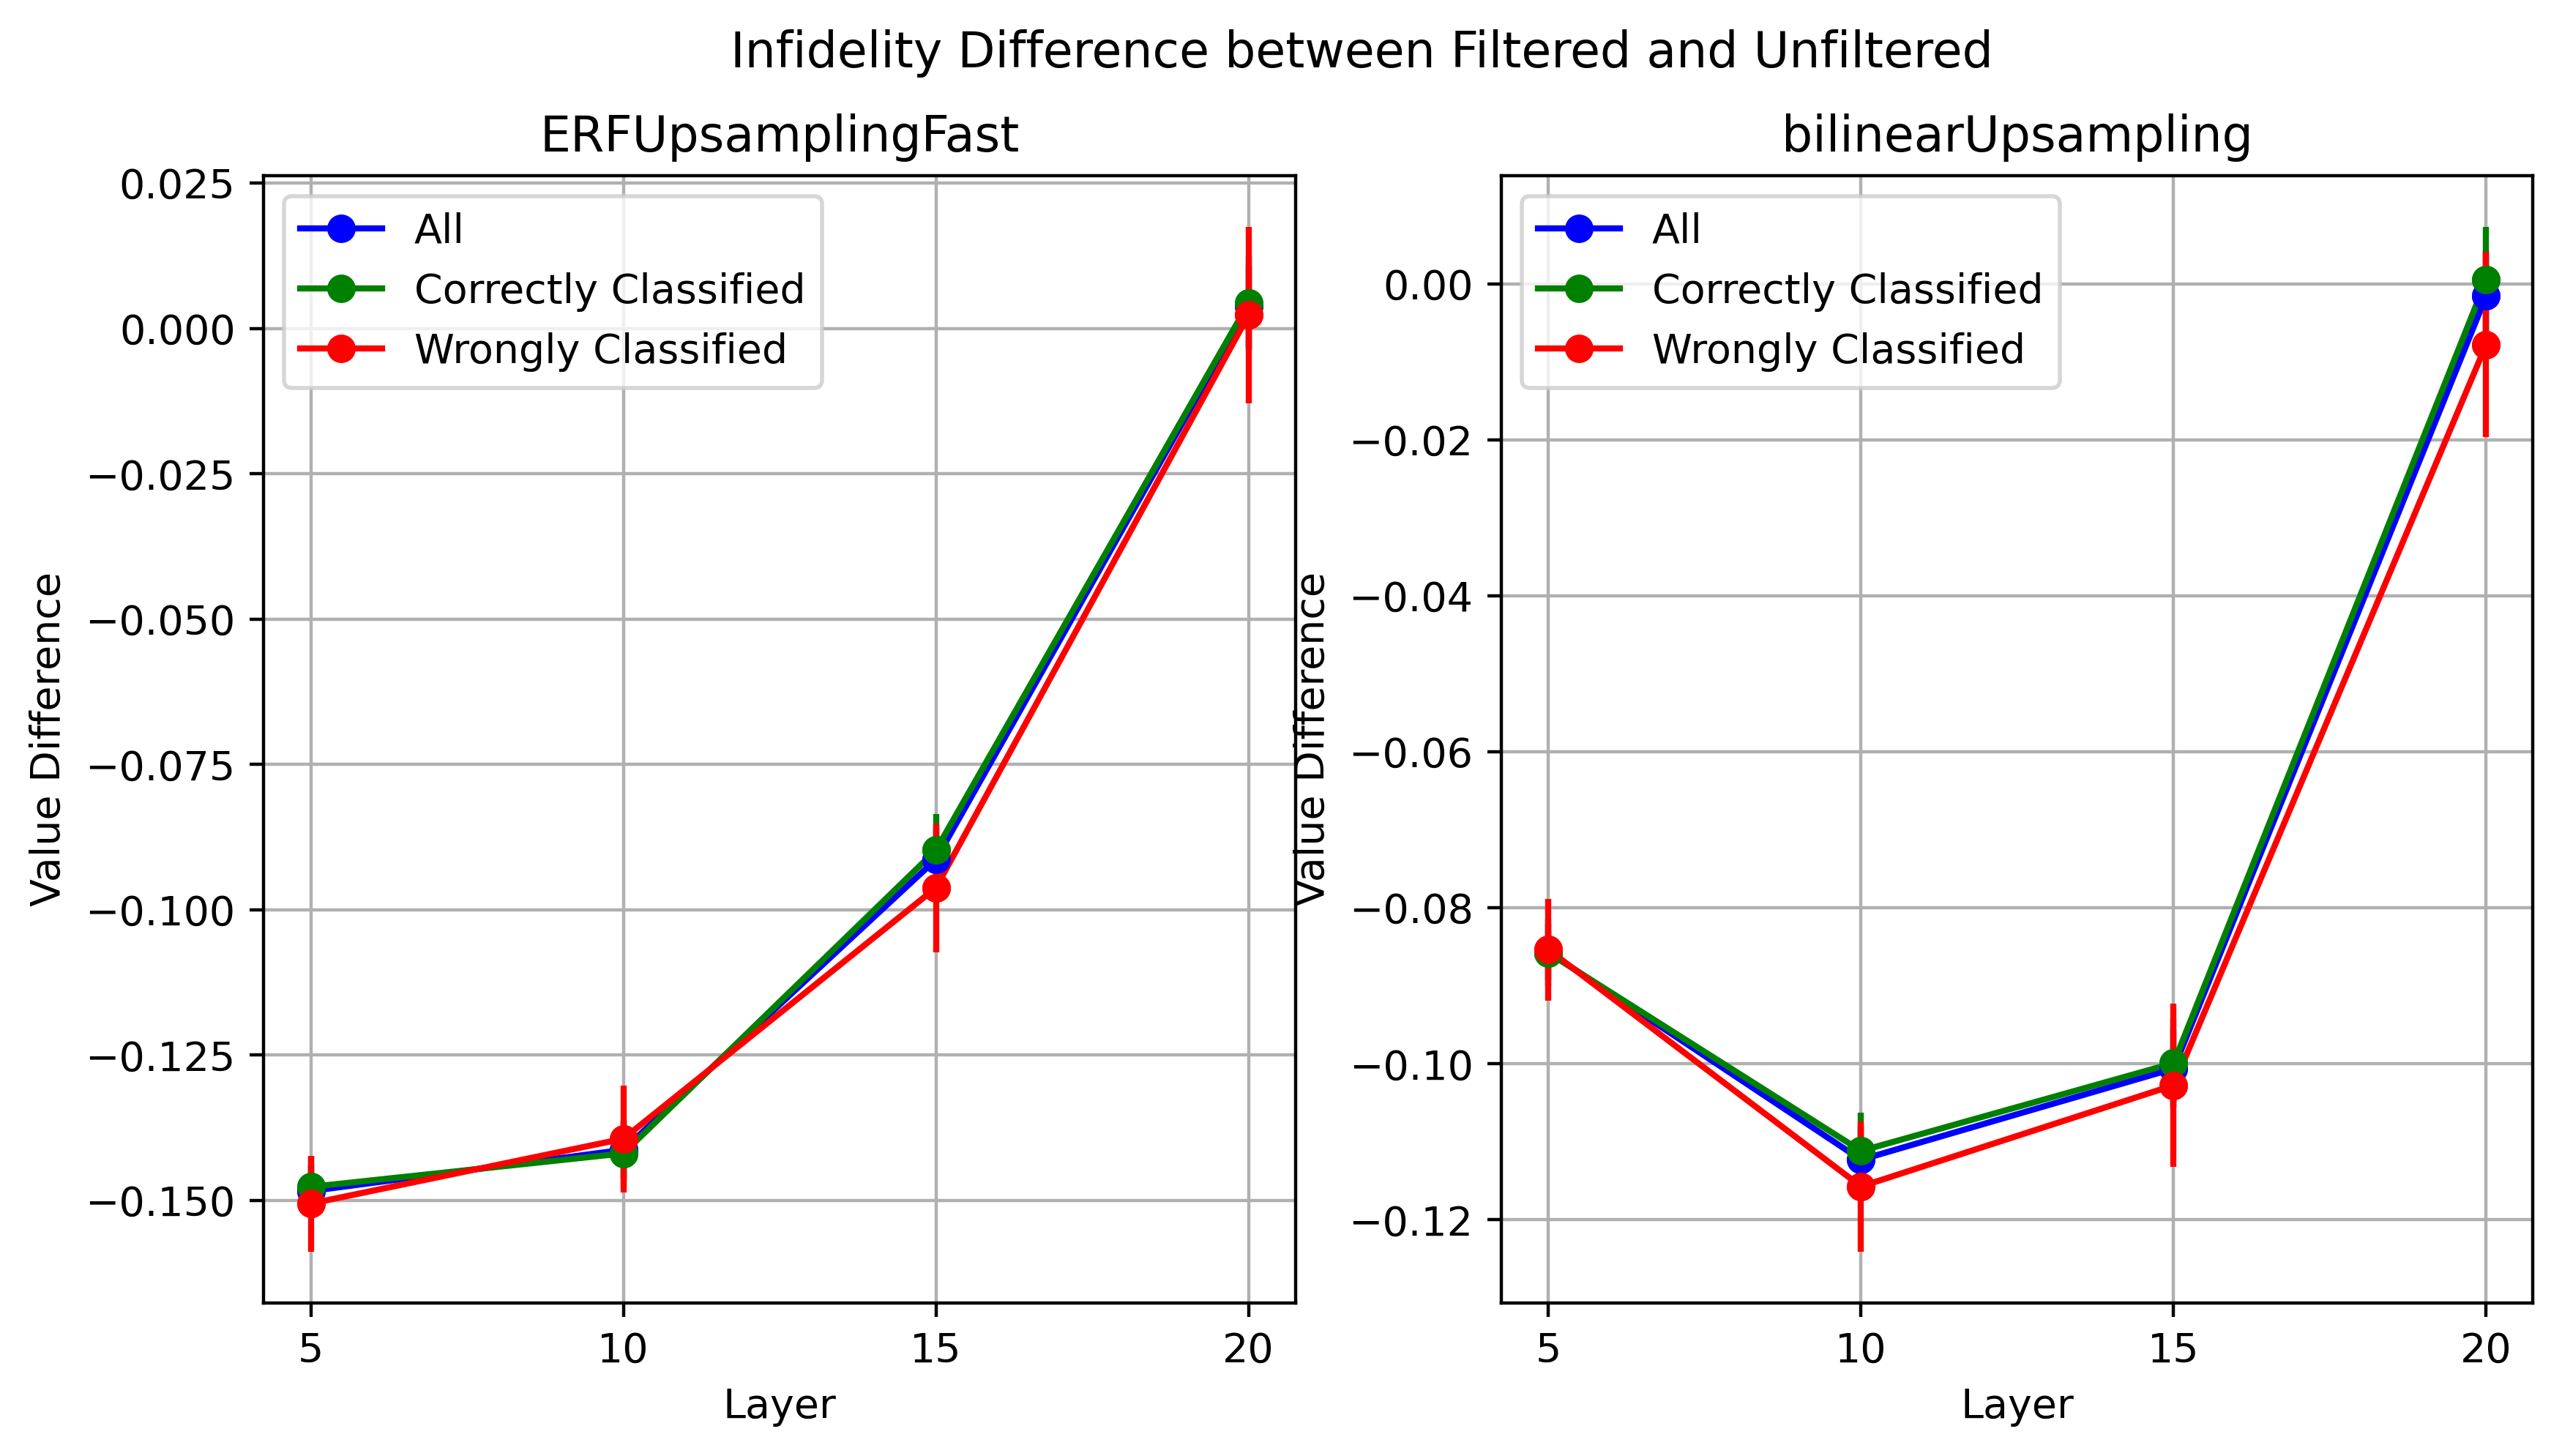

In [ ]:
# Plot the grouped data showing also the 95% confidence interval
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.patches as mpatches

import numpy as np


# Function to calculate the difference in 'Value' for each group
def calculate_difference(group):
    if len(group) == 2:
        # Assuming there are exactly two rows in each group with different 'Mixing Method'
        diff = group['Value'].diff().iloc[1]
        return pd.Series([diff], index=['Value Difference'])
    else:
        return pd.Series([None], index=['Value Difference'])


# Apply the function to each group and reset the index
# display(grouped)

plt.figure(figsize=(10,5), dpi=400)
plt.suptitle("Infidelity Difference between Filtered and Unfiltered")
# plt.xlabel("Layer")
# plt.ylabel("Value Difference")
# plt.xticks([5,10,15,20])
# plt.ylim([-0.1, 0.4])
# plt.grid(True)
# Plot data

grouped = df.groupby([col for col in df.columns if col not in ['Mixing Method', 'Value']])

# df_correct = df[df["Predicted Label"] == df["Label"]]
# grouped_correct = df_correct.groupby([col for col in df_correct.columns if col not in ['Mixing Method', 'Value']])

# df_wrong = df[df["Predicted Label"] != df["Label"]]
# grouped_wrong = df_wrong.groupby([col for col in df_wrong.columns if col not in ['Mixing Method', 'Value']])

colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
labels = ['All', 'Correctly Classified', 'Wrongly Classified']

for index, upscale in enumerate(upscale_methods):
    plt.subplot(1, 2, index + 1)
    plt.title(upscale)
    plt.grid(True)
    plt.xlabel("Layer")
    plt.ylabel("Value Difference")
    # plt.ylim([-0.01, 0.12])
    plt.xticks([5,10,15,20])
     
    grouped = grouped.apply(calculate_difference).reset_index()
    print(grouped)
    grouped = grouped[grouped["Upscale Method"] == upscale]        
    grouped = grouped.groupby(["Layer"]).agg({"Value Difference": ["mean","std", "count"]}).reset_index()
    grouped["Layer"] = grouped["Layer"].apply(lambda x: int(x.split(".")[-1]))
    grouped = grouped.sort_values(by="Layer")
    plt.plot(grouped["Layer"], grouped['Value Difference']['mean'], marker='o', label=labels[index], color=colors[index])
    for i, row in grouped.iterrows():
        layer = int(row['Layer'].values[0])
        mean_diff = row['Value Difference']['mean']
        std_diff = 1.96*row['Value Difference']['std'] / np.sqrt(row['Value Difference']['count'])

        # Plot the mean difference with error bars
        plt.errorbar(layer, mean_diff, yerr=std_diff, fmt='o', color=colors[index])

    plt.legend()

plt.savefig('results mixed difference infidelity.pdf', dpi=400, bbox_inches='tight')

C:\Users\Luca\AppData\Local\Temp\ipykernel_14780\1514218077.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_values["Layer"] = filtered_values["Layer"].apply(lambda x: int(x.split(".")[-1]))
C:\Users\Luca\AppData\Local\Temp\ipykernel_14780\1514218077.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_values["Layer"] = filtered_values["Layer"].apply(lambda x: int(x.split(".")[-1]))


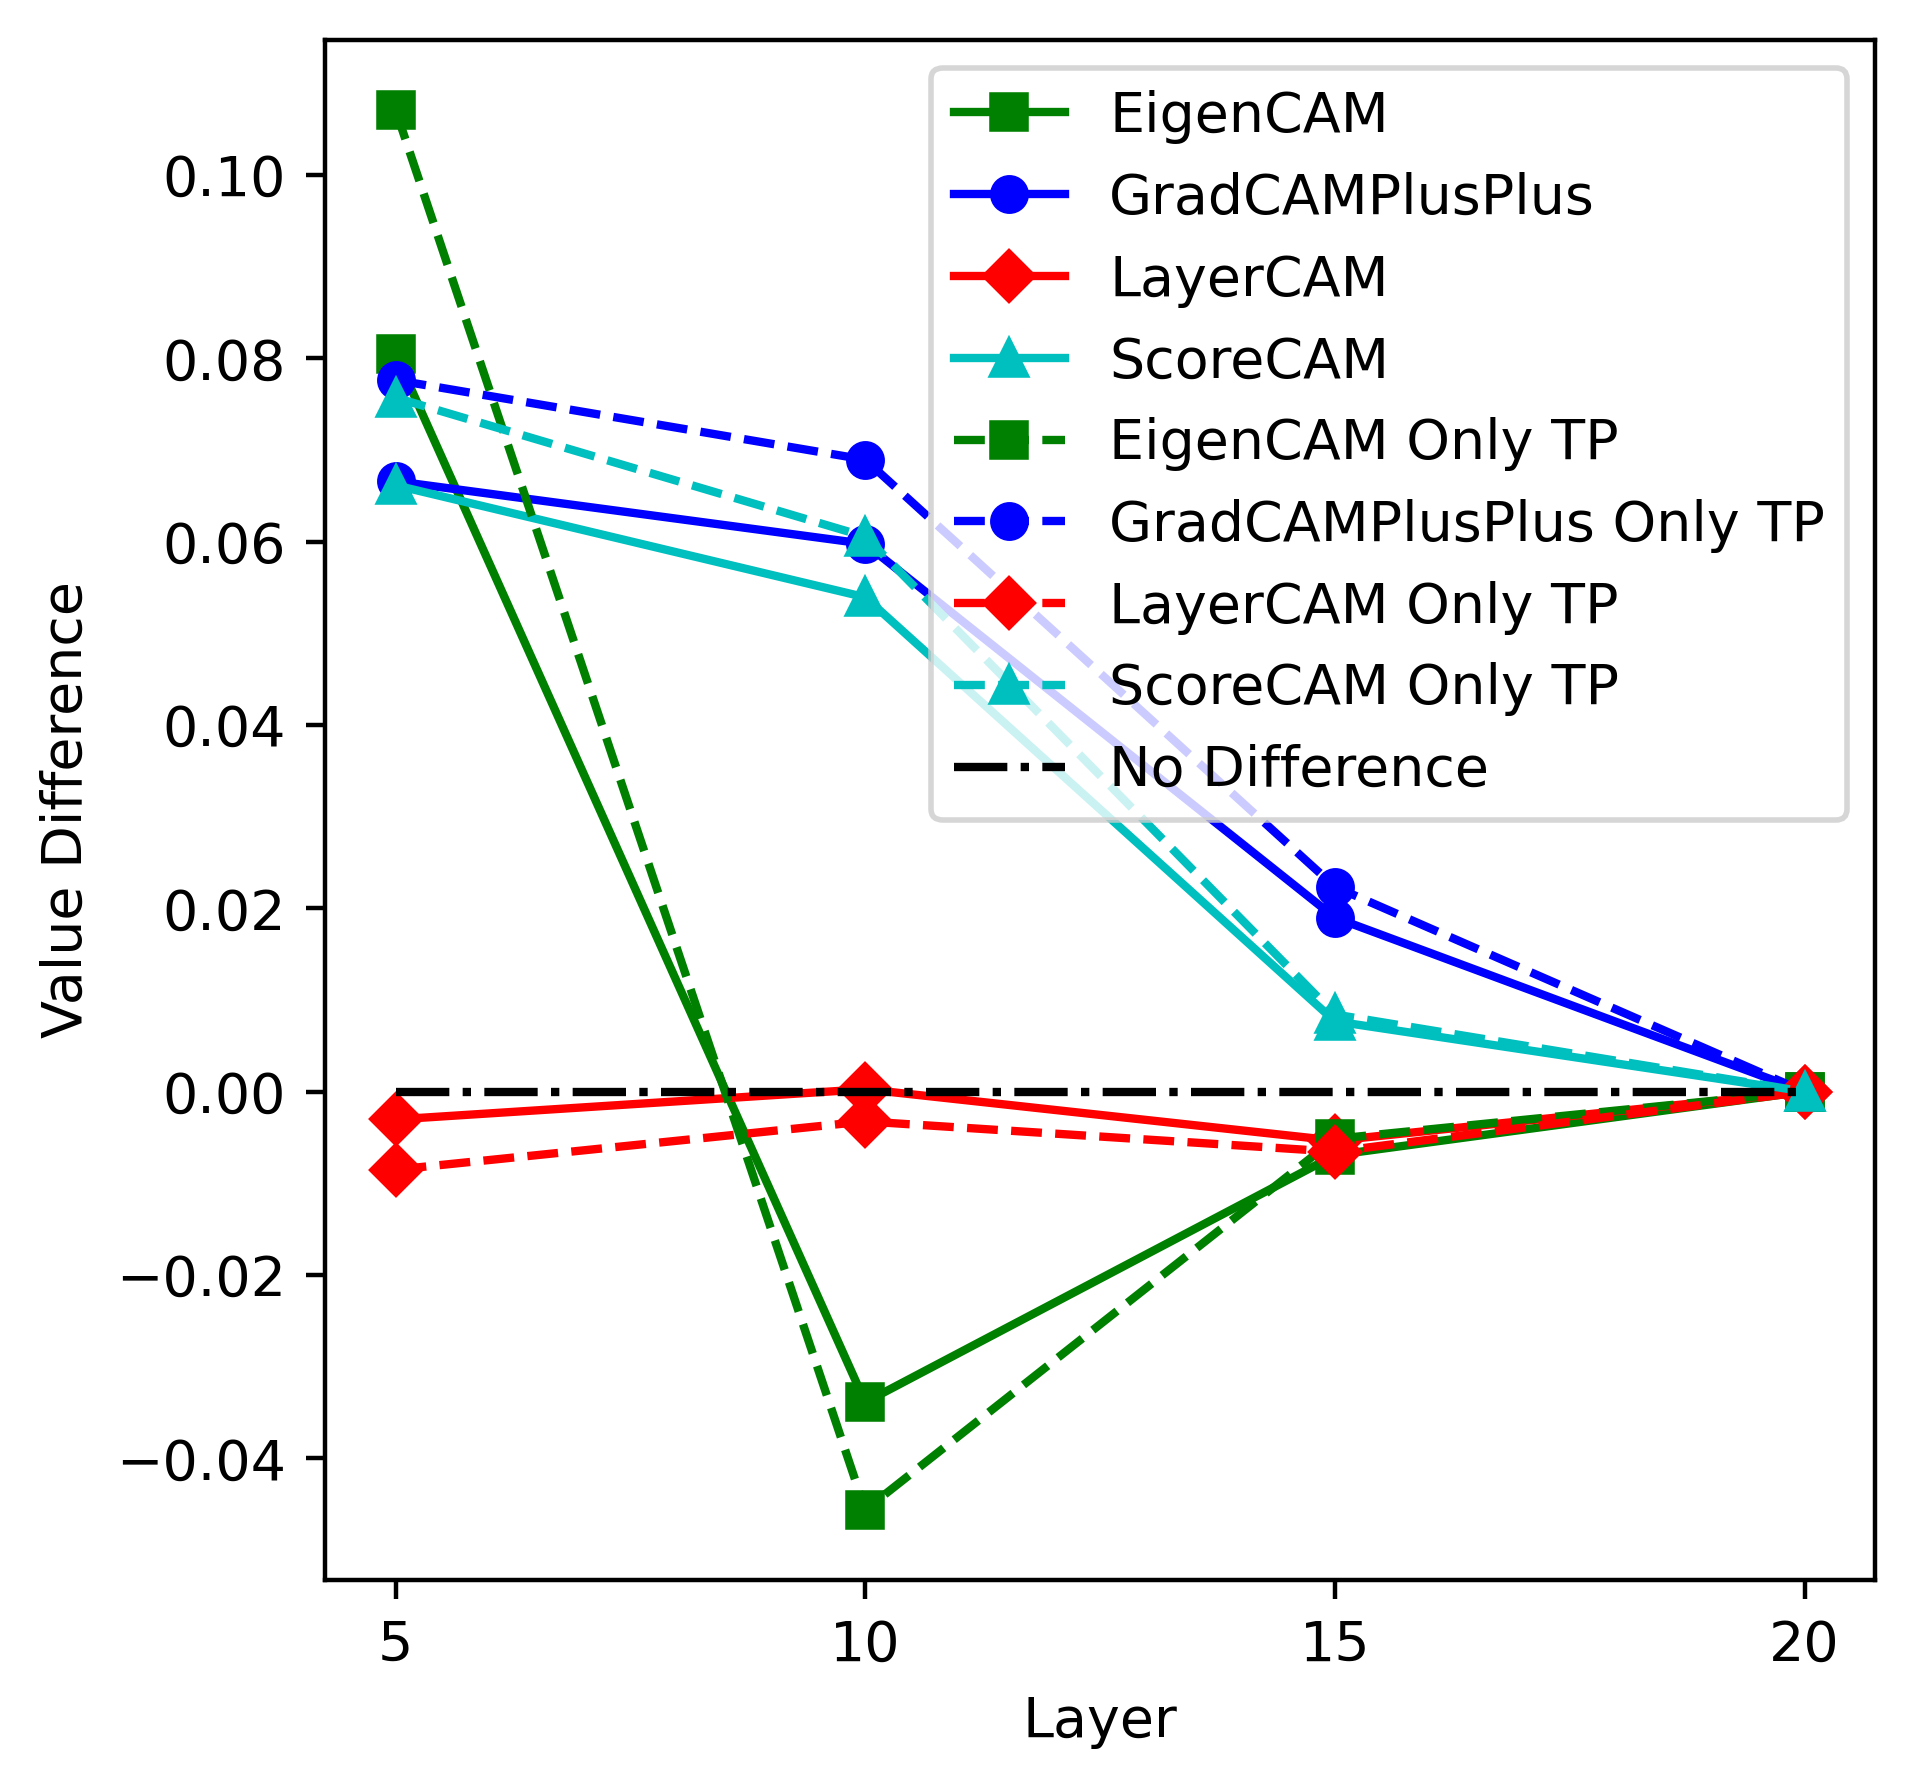

In [35]:
metrics = ["road_combined"]

def calculate_difference(group):
    if len(group) == 2:
        # Assuming there are exactly two rows in each group with different 'Mixing Method'
        diff = group['Value'].diff().iloc[1]
        return pd.Series([diff], index=['Value Difference'])
    else:
        return pd.Series([None], index=['Value Difference'])
    
marker_for_method = {
    "GradCAMPlusPlus": "o",
    "EigenCAM": "s",
    "LayerCAM": "D",
    "ScoreCAM": "^"}

color_for_method = {
    "GradCAMPlusPlus": "b",
    "EigenCAM": "g",
    "LayerCAM": "r",
    "ScoreCAM": "c"}

df_correct = df[df["Predicted Label"] == df["Label"]]
    
df_linestyles = ["-", "--"]

plt.figure(figsize=(5,5), dpi=400)

for df_index, d in enumerate([df, df_correct]):
    for metric in metrics:
        metric_df = d[d["Metric"] == metric]    
        grouped = metric_df.groupby([col for col in metric_df.columns if col not in ['Mixing Method', 'Value']]).apply(calculate_difference).reset_index()
        values = grouped.groupby(["Attribution Method", "Layer", "Upscale Method"]).agg({"Value Difference": ["mean","std", "count"]}).reset_index()
        # display(values)

        for method in methods:
            for upscale in upscale_methods[:1]:
                filtered_values = values[(values["Attribution Method"] == method) & (values["Upscale Method"] == upscale)]

                filtered_values["Layer"] = filtered_values["Layer"].apply(lambda x: int(x.split(".")[-1]))
                filtered_values = filtered_values.sort_values(by="Layer")
                plt.plot(filtered_values["Layer"],
                         filtered_values['Value Difference']['mean'],
                         marker=marker_for_method[method],
                         label=method + (" Only TP" if df_index == 1 else ""),
                         linestyle=df_linestyles[df_index],
                         color=color_for_method[method])
                
                plt.xticks([5,10,15,20])
                plt.xlabel("Layer")
                plt.ylabel("Value Difference")
                # display(filtered_values)

plt.plot([5,10,15,20], [0,0,0,0], linestyle="dashdot", color="black", label="No Difference")
plt.legend()